## Vehicle Detection Project

The goals / steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
2. Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
3. Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
4. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
5. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
6. Estimate a bounding box for vehicles detected.

**Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier**

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

print('start...')

start...


In [2]:
car_images = glob.glob('trainning_dataset/vehicles/*/*.png')
#car_images = glob.glob(r"training_dataset/v/*")
noncar_images = glob.glob('trainning_dataset/non-vehicles/*/*.png')
#print(car_images)
#print(noncar_images)
print(len(car_images), len(noncar_images))

8792 8968


**Visualize Some Of The Data**

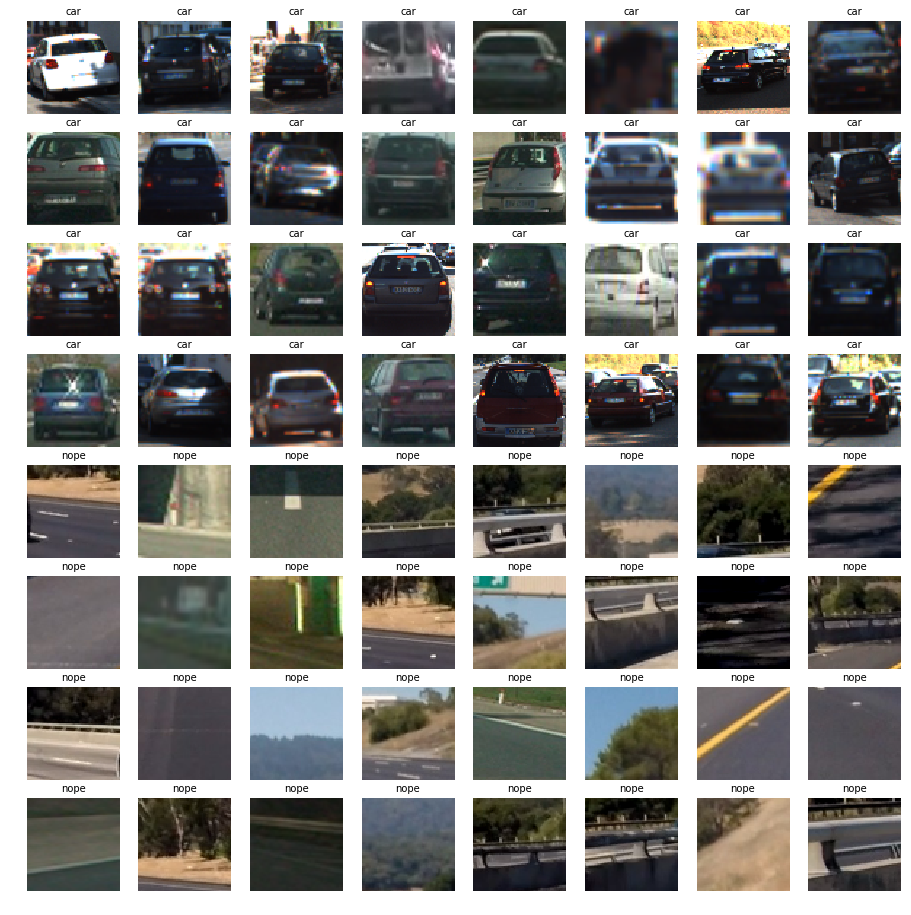

In [3]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('nope', fontsize=10)
    axs[i].imshow(img)

**Define Method to Convert Image to Histogram of Oriented Gradients (HOG)**

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

print('def get_hog_freatures')


def get_hog_freatures


**Visualize HOG on example image**

Text(0.5,1,'Non-Car HOG')

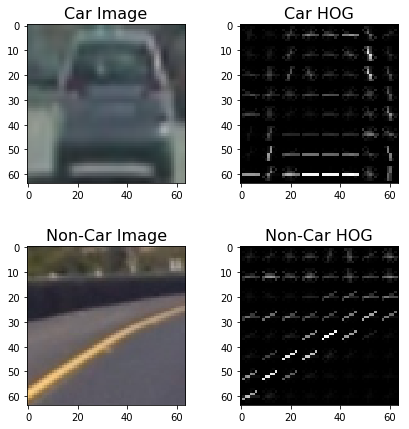

In [5]:
car_img = mpimg.imread(car_images[5])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[5])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

**Method to Extract HOG Features from an Array of Car and Non-Car Images**

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [8]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

**Extract Features for Input Datasets and Combine, Define Labels Vector, Shuffle and Split**

In [9]:
# Feature extraction parameters
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
# spatial_size = (16, 16) # Spatial binning dimensions
# hist_bins = 16    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off
# hog_feat = True # HOG features on or off
# y_start_stop = [None, None] # Min and max in y to search in slide_window()




t = time.time()
# car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
#                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel)
# notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
#                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel)

car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(noncar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

99.04 Seconds to extract HOG features...
Using: 15 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 11988


**Train a Classifier**

In [10]:
# # Fit a per-column scaler
# X_scaler = StandardScaler().fit(X_train)
# # Apply the scaler to X
# X_train = X_scaler.transform(X_train)
# X_test = X_scaler.transform(X_test)
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

35.51 Seconds to train SVC...
Test Accuracy of SVC =  0.989


**Method for Using Classifier to Detect Cars in an Image**

**Test Find_Cars on an Example Image**

In [11]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]  # sub-sampling
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #nblocks_per_window = (window // pix_per_cell)-1 

    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
   
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(test_stacked)    
            #test_features = scaler.transform(np.array(features).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))

    return draw_img, bboxes

In [12]:
test_img = mpimg.imread('./test_series/series1.jpg')  
bboxes = []
ystart = 400
ystop = 500 
out_img,bboxe1 = find_cars(test_img, ystart, ystop, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

print(len(out_img), 'rectangles found in image')

            

714 rectangles found in image


***Method to Draw Rectangles onto an Image***

In [13]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

...


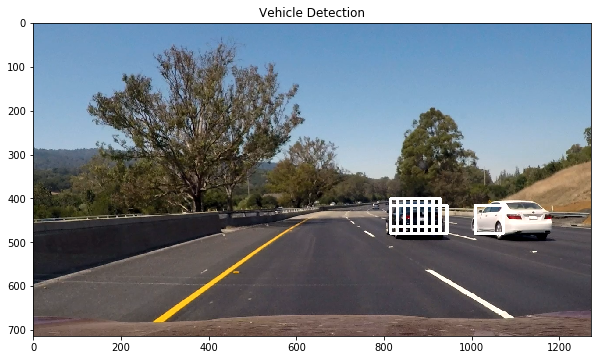

In [14]:
#test_img_rects = draw_boxes(test_img, rectangles)
# window_img = draw_boxes(out_img,1, color=(0, 0, 255), thick=6) 
plt.figure(figsize=(10,10))
plt.title('Vehicle Detection')
plt.imshow(out_img)
print('...')

***Sliding window***

In [15]:
def apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bboxes = []
    ystart = 400
    ystop = 500 
    out_img, bboxes1 = find_cars(image, ystart, ystop, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 500 
    out_img, bboxes2 = find_cars(out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 410
    ystop = 500 
    out_img, bboxes3 = find_cars(out_img, ystart, ystop, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 420
    ystop = 556 
    out_img, bboxes4 = find_cars(out_img, ystart, ystop, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes5 = find_cars (out_img, ystart, ystop, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes6 = find_cars (out_img, ystart, ystop, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 440
    ystop = 556 
    out_img, bboxes7 = find_cars (out_img, ystart, ystop, 1.9, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes8 = find_cars (out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes9 = find_cars (out_img, ystart, ystop, 2.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 500 
    ystop = 656 
    out_img, bboxes10 = find_cars (out_img, ystart, ystop, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bboxes1)
    bboxes.extend(bboxes2)
    bboxes.extend(bboxes3)
    bboxes.extend(bboxes4)
    bboxes.extend(bboxes5)
    bboxes.extend(bboxes6)
    bboxes.extend(bboxes7)
    bboxes.extend(bboxes8)
    bboxes.extend(bboxes9)
    bboxes.extend(bboxes10)
    
    return out_img, bboxes

def show_images(image1, image2, image3,  image1_exp="Image 1", image2_exp="Image 2", image3_exp="Image 3"):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2)
    ax2.set_title(image2_exp, fontsize=20)
    ax3.imshow(image3)
    ax3.set_title(image3_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

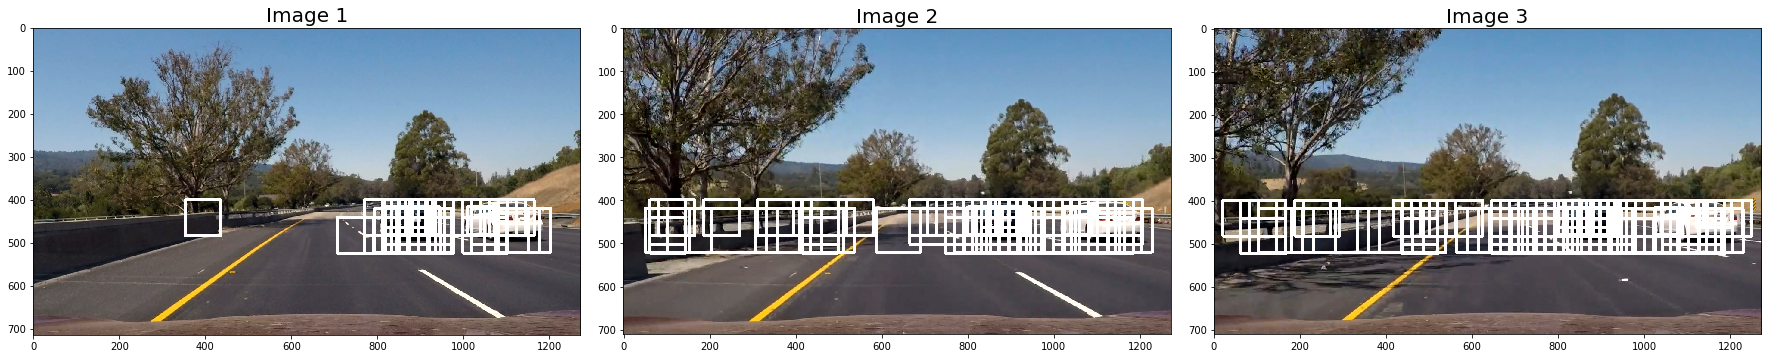

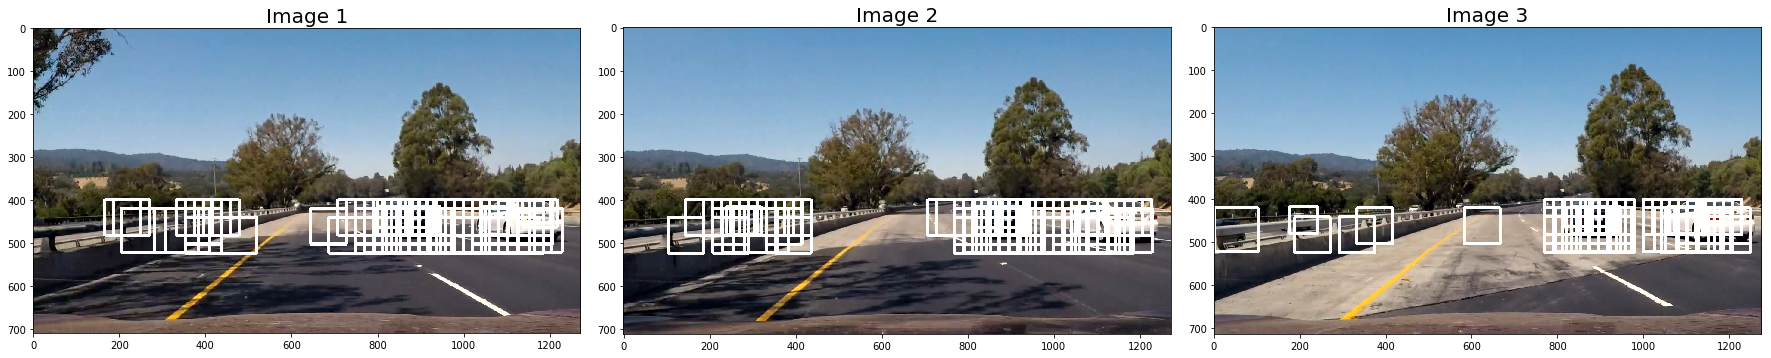

In [16]:
image1 = mpimg.imread('./test_series/series1.jpg')
image2 = mpimg.imread('./test_series/series2.jpg')
image3 = mpimg.imread('./test_series/series3.jpg')
image4 = mpimg.imread('./test_series/series4.jpg')
image5 = mpimg.imread('./test_series/series5.jpg')
image6 = mpimg.imread('./test_series/series6.jpg')

output_image1, bboxes1 = apply_sliding_window(image1, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image2, bboxes2 = apply_sliding_window(image2, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image3, bboxes3 = apply_sliding_window(image3, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image4, bboxes4 = apply_sliding_window(image4, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image5, bboxes5 = apply_sliding_window(image5, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image6, bboxes6 = apply_sliding_window(image6, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)

image = mpimg.imread('./test_images/test4.jpg')
draw_image = np.copy(image)
output_image, bboxes = apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)

show_images(output_image1, output_image2, output_image3)
show_images(output_image4, output_image5, output_image6)

***make a heat-map***

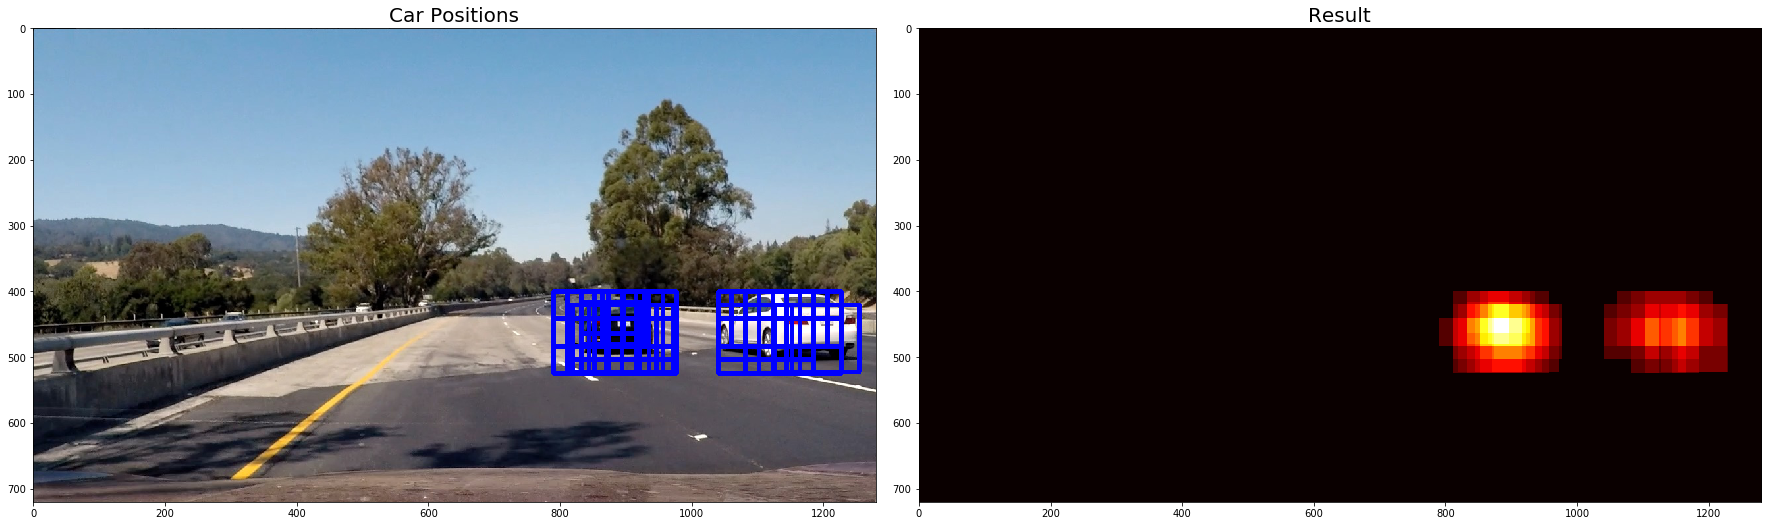

In [18]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

#define hear
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,bboxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

def show_images(image1, image2,  image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2, cmap='hot')
    ax2.set_title(image2_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
show_images(output_image, heatmap, "Car Positions", "Result")

***Rectangle in image***

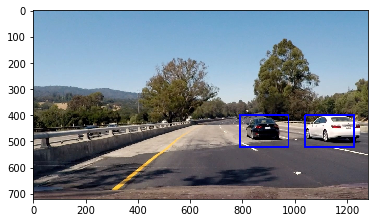

In [20]:
plt.imshow(draw_img)

### video dection

In [25]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

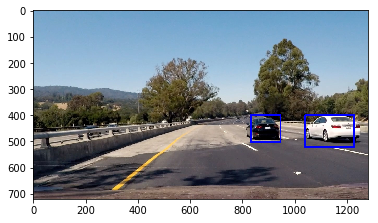

In [26]:
def detect_cars(image):
    bboxes = []
    ystart = 400
    ystop = 500 
    out_img, bboxes1 = find_cars(image, ystart, ystop, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 500 
    out_img, bboxes2 = find_cars(image, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 410
    ystop = 500 
    out_img, bboxes3 = find_cars(out_img, ystart, ystop, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 420
    ystop = 556 
    out_img, bboxes4 = find_cars(out_img, ystart, ystop, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes5 = find_cars (out_img, ystart, ystop, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes6 = find_cars (out_img, ystart, ystop, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 440
    ystop = 556 
    out_img, bboxes7 = find_cars (out_img, ystart, ystop, 1.9, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes8 = find_cars (out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes9 = find_cars (out_img, ystart, ystop, 2.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 500 
    ystop = 656 
    out_img, bboxes10 = find_cars (out_img, ystart, ystop, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bboxes1)
    bboxes.extend(bboxes2)
    bboxes.extend(bboxes3)
    bboxes.extend(bboxes4)
    bboxes.extend(bboxes5)
    bboxes.extend(bboxes6)
    bboxes.extend(bboxes7)
    bboxes.extend(bboxes8)
    bboxes.extend(bboxes9)
    bboxes.extend(bboxes10)
   
    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)

    # Apply threshold to help remove false positives
    threshold = 1 
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    current_heatmap = np.clip(heat, 0, 255)
    history.append(current_heatmap)
    
    heatmap = np.zeros_like(current_heatmap).astype(np.float)
    for heat in history:
        heatmap = heatmap + heat

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img
    
img = detect_cars(image)
plt.imshow(img)

In [27]:
history = deque(maxlen = 8)
output = 'test_result.mp4'
clip = VideoFileClip("test_video.mp4")
video_clip = clip.fl_image(detect_cars)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_result.mp4
[MoviePy] Writing video test_result.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:37<00:00,  1.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_result.mp4 

Wall time: 38.2 s


In [28]:
history = deque(maxlen = 8)
output = 'result.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(detect_cars)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [20:41<00:00,  1.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

Wall time: 20min 42s
